In [ ]:
# ライブラリをインポート
import pandas as pd
# a列、b列を作成
a = [num for num in range(10, 101, 10)]
b = [num for num in range(1, 11)]
# データ・フレームを作成
df = pd.DataFrame(list(zip(a, b)), columns = ['a', 'b'])
df['multiplication'] = df['a'] * df['b']
print(df)
# べきを集計
df['power'] = df['a']**df['b']
print(df)

     a   b  multiplication
0   10   1              10
1   20   2              40
2   30   3              90
3   40   4             160
4   50   5             250
5   60   6             360
6   70   7             490
7   80   8             640
8   90   9             810
9  100  10            1000


In [ ]:
df['power'] = pow(df['a'], df['b'])
print(df)

     a   b  multiplication                power
0   10   1              10                   10
1   20   2              40                  400
2   30   3              90                27000
3   40   4             160              2560000
4   50   5             250            312500000
5   60   6             360          46656000000
6   70   7             490        8235430000000
7   80   8             640     1677721600000000
8   90   9             810   387420489000000000
9  100  10            1000  7766279631452241920


In [ ]:
candidate_sentences['sentence'].sample(5)

809     it is technically a uk production, financed by 20th century-fox's british subsidiary.
3110                        he then attended the prestigious kodaikanal international school.
157                                 affleck as bruce wayne / batman and miller as barry allen
7           later, craig di francia and action bronson were revealed to have joined the cast.
1239                                         one exception is starchaser: the legend of orin.
Name: sentence, dtype: object

In [ ]:
doc = nlp("the drawdown process is governed by astm standard d823")

for tok in doc:
  print(tok.text, "...", tok.dep_)

the ... det
drawdown ... amod
process ... nsubjpass
is ... auxpass
governed ... ROOT
by ... agent
astm ... compound
standard ... amod
d823 ... pobj


In [ ]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [ ]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [ ]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 4318/4318 [00:43<00:00, 98.27it/s]


In [ ]:
entity_pairs[10:20]

[['we', 'tests'],
 ['m global', 'international sales rights'],
 ['robbie robertson', 'soundtrack'],
 ['it', 'original music tracks'],
 ['it', 'reviewed  franchise'],
 ['she', 'accidentally  mystique'],
 ['', 'military  arrest'],
 ['train', 'vuk'],
 ['telepath', 'gallio'],
 ['singer', 'men']]

In [ ]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [ ]:
get_relation("John completed the task")

'completed'

In [ ]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 4318/4318 [00:42<00:00, 101.96it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

is               370
was              297
released on       87
include           73
were              71
are               71
released          40
's                38
composed by       35
have              31
became            31
has               31
become            29
released in       27
included          26
called            22
produced          22
considered        20
made              20
had               20
been              18
be                18
scheduled         17
used              17
directed by       16
stars             16
written by        15
hired             14
wrote             14
produced by       14
set               14
received          13
introduced in     13
went              13
wanted            12
began in          11
won               11
began             11
gave              10
features          10
sold              10
produced in        9
known as           9
shot in            9
reported           9
opened             9
gives              9
includes     

In [ ]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})


In [ ]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


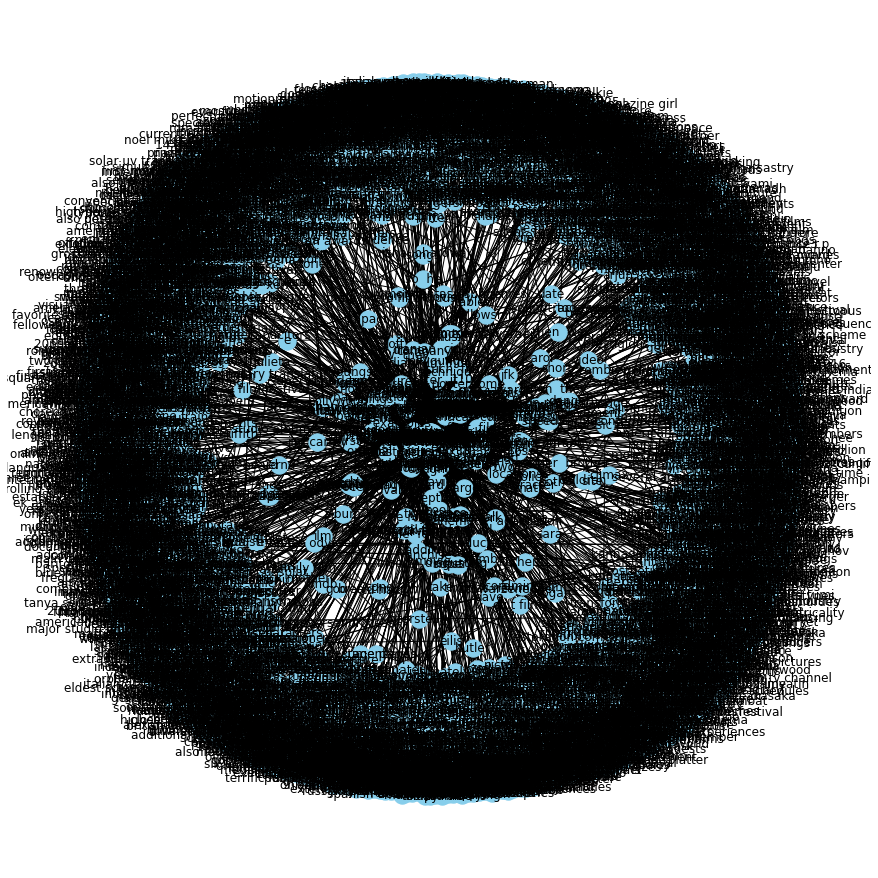

In [ ]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

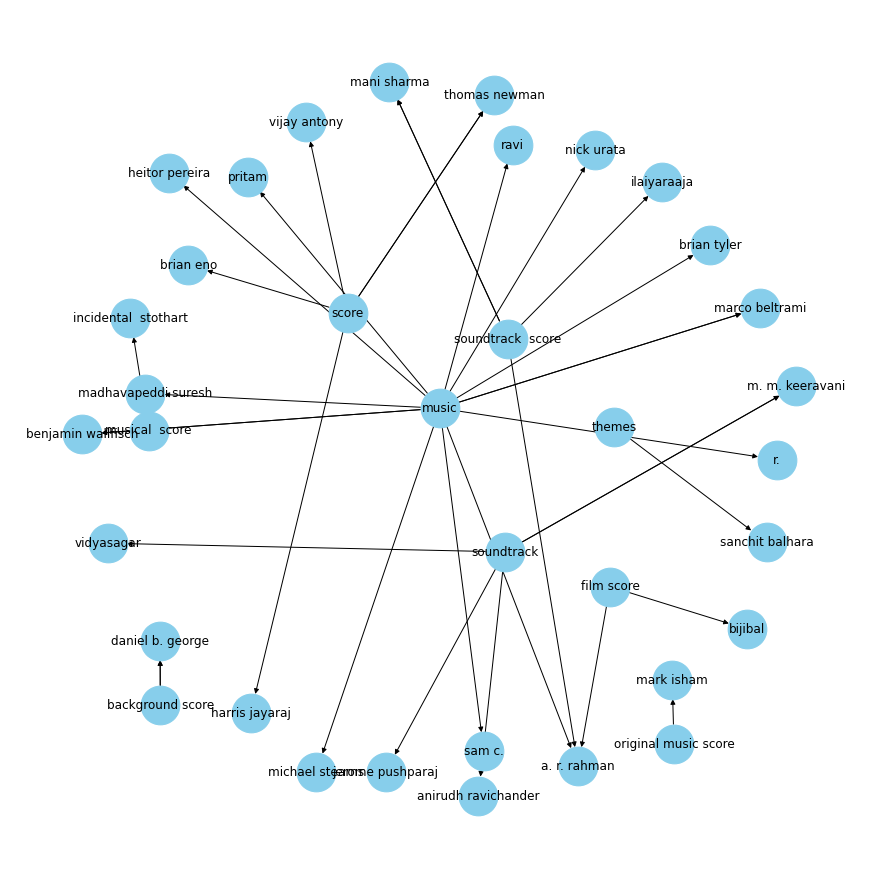

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="composed by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

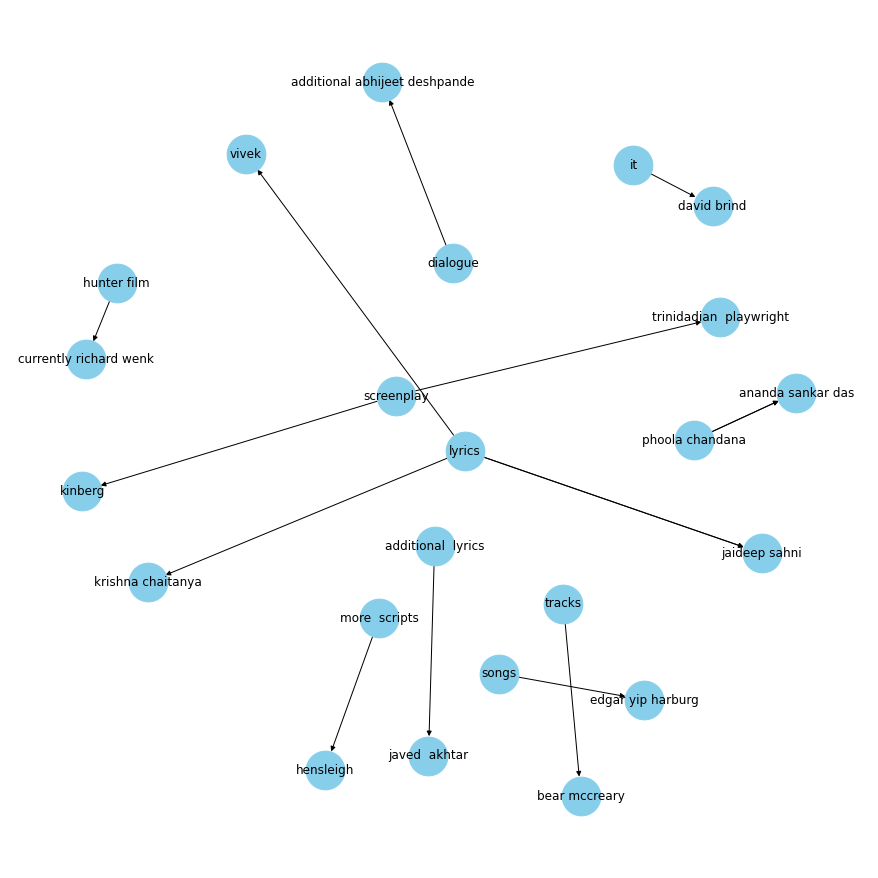

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="written by"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

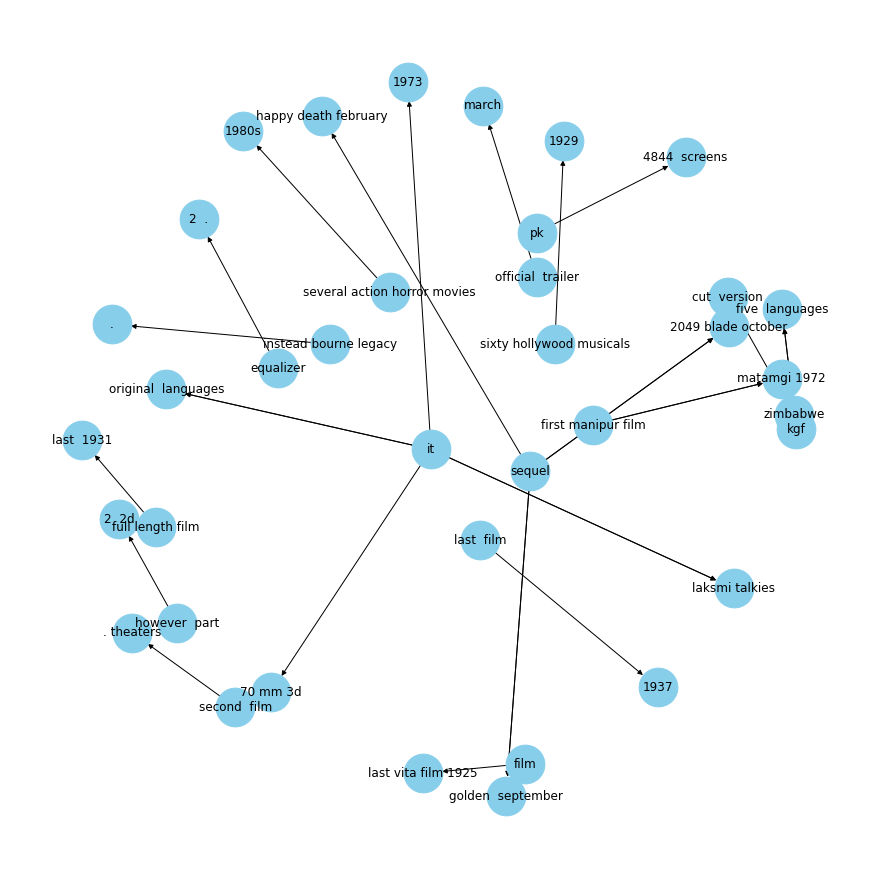

In [ ]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="released in"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()